In [ ]:
# this notebook will take the saved mean between subj and within subj correlations in the fixed effects and individual contrasts 
# it will look at which ROIs are the best fit per task, and if it's the one we'd expect given the main executive functions targeted by the task.

In [13]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict

In [14]:
# load the mean data for fixed effects and indiv contrast
with open('correlation_analysis_results/fe_corrs_dict.pkl', 'rb') as f:
    fe_corrs_dict = pickle.load(f)
with open('correlation_analysis_results/indiv_corrs_dict.pkl', 'rb') as f:
    indiv_corrs_dict = pickle.load(f)

In [15]:
print(fe_corrs_dict)
print(indiv_corrs_dict)

{'nBack': {'twoBack-oneBack': {'brain_roi': ['whole-brain', 'working-memory', 'attentional-control', 'inhibitory-control', 'dlpfc', 'acc', 'ips'], 'corrs': [0.07866084643433041, 0.3196300515475999, 0.4474866829251495, 0.2544104230877514, 0.2748079822761948, 0.31606185469152775, 0.34761332962602143]}, 'task-baseline': {'brain_roi': ['whole-brain', 'working-memory', 'attentional-control', 'inhibitory-control', 'dlpfc', 'acc', 'ips'], 'corrs': [0.27271095596421585, 0.2557523364115544, 0.15418413882720322, 0.2972483718219506, 0.12306915636499252, 0.3170777118783188, 0.3767119059950737]}}, 'flanker': {'incongruent-congruent': {'brain_roi': ['whole-brain', 'working-memory', 'attentional-control', 'inhibitory-control', 'dlpfc', 'acc', 'ips'], 'corrs': [7.637880582349581e-05, 0.0210229000401141, 0.2407327007769398, 0.02867637604013677, 0.08751865645498175, 0.12445083680716862, 0.0205211877860148]}, 'task-baseline': {'brain_roi': ['whole-brain', 'working-memory', 'attentional-control', 'inhibit

# fixed effects:

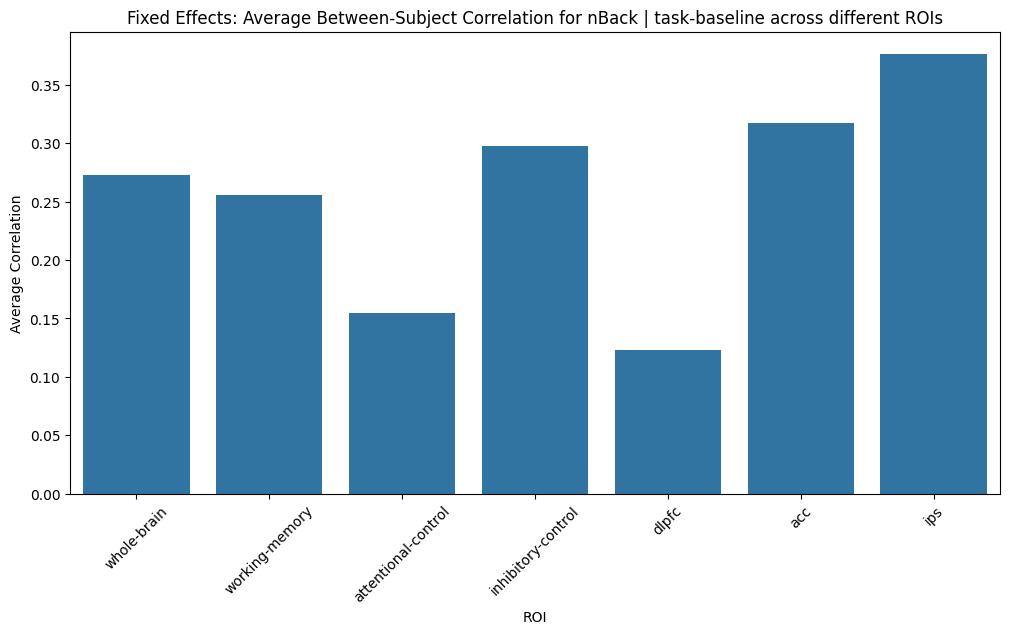

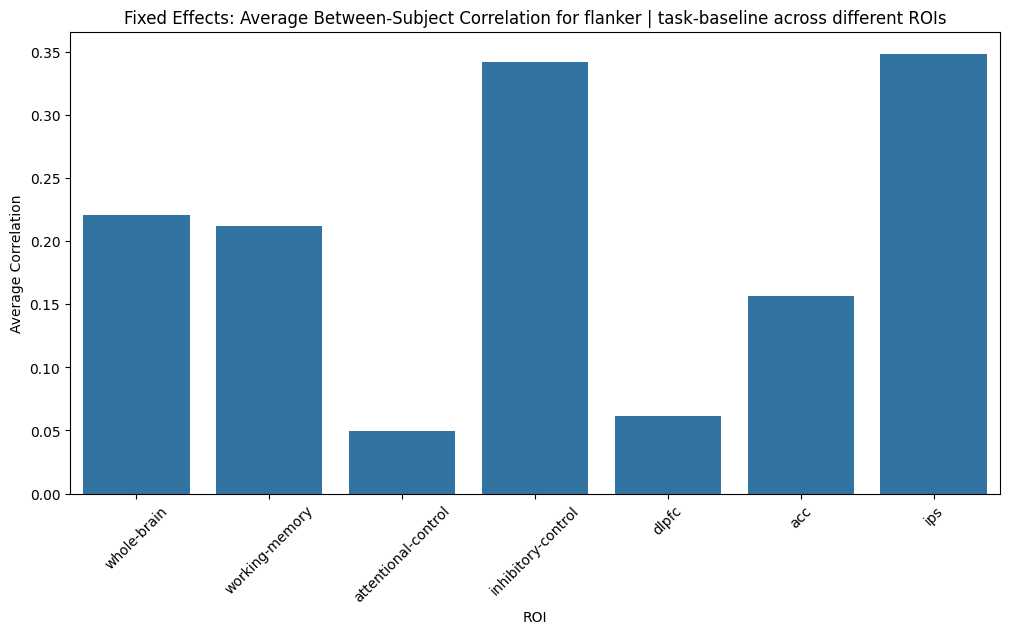

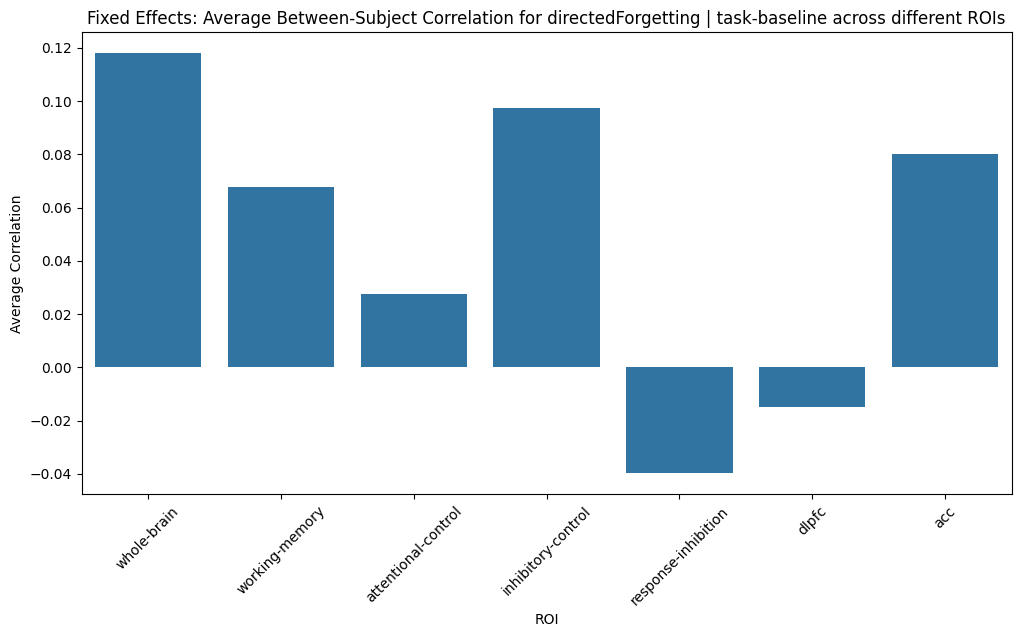

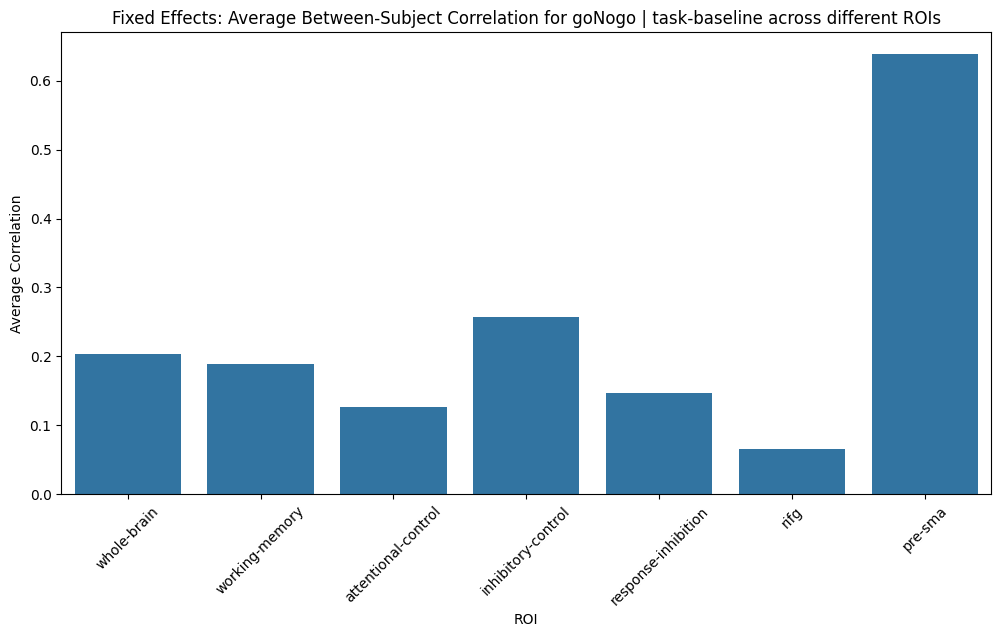

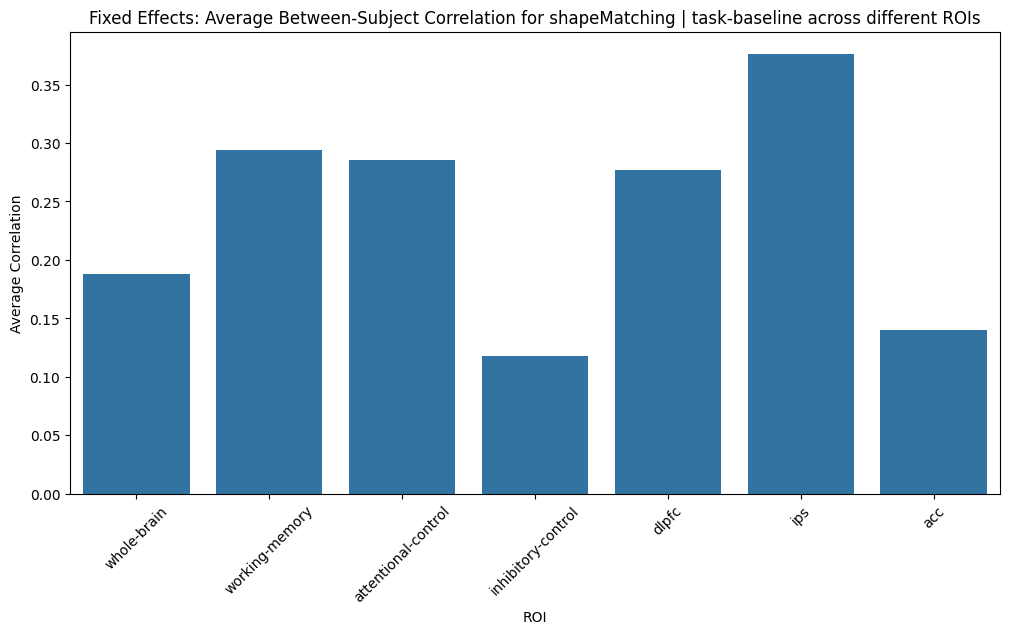

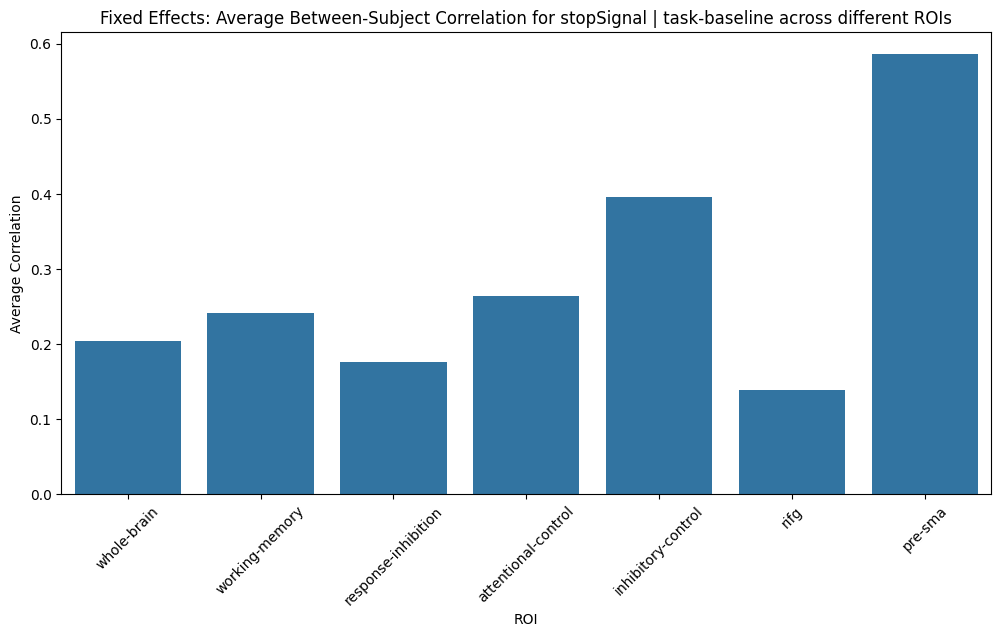

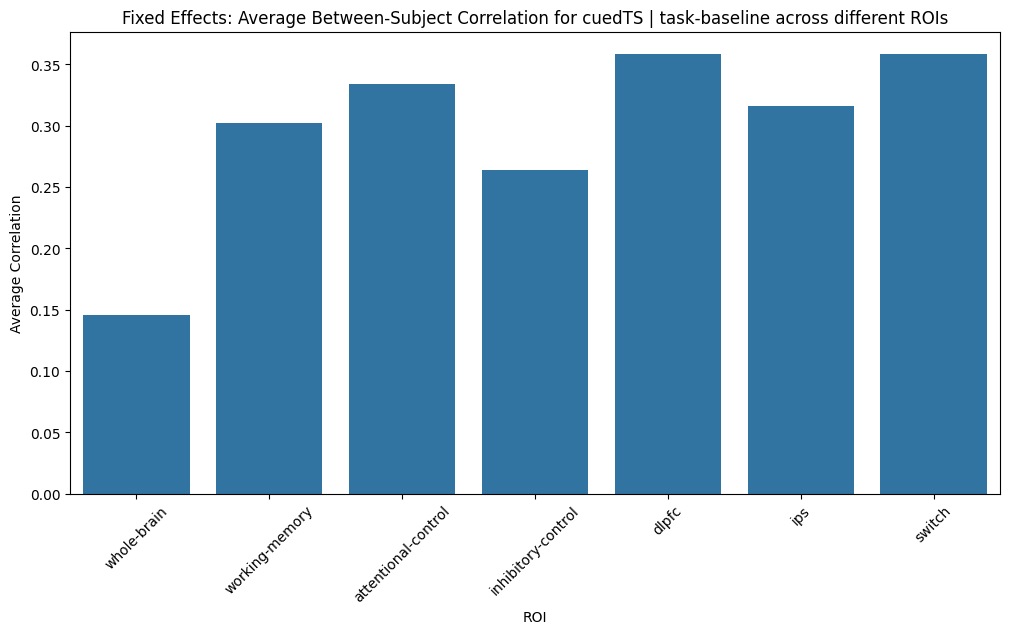

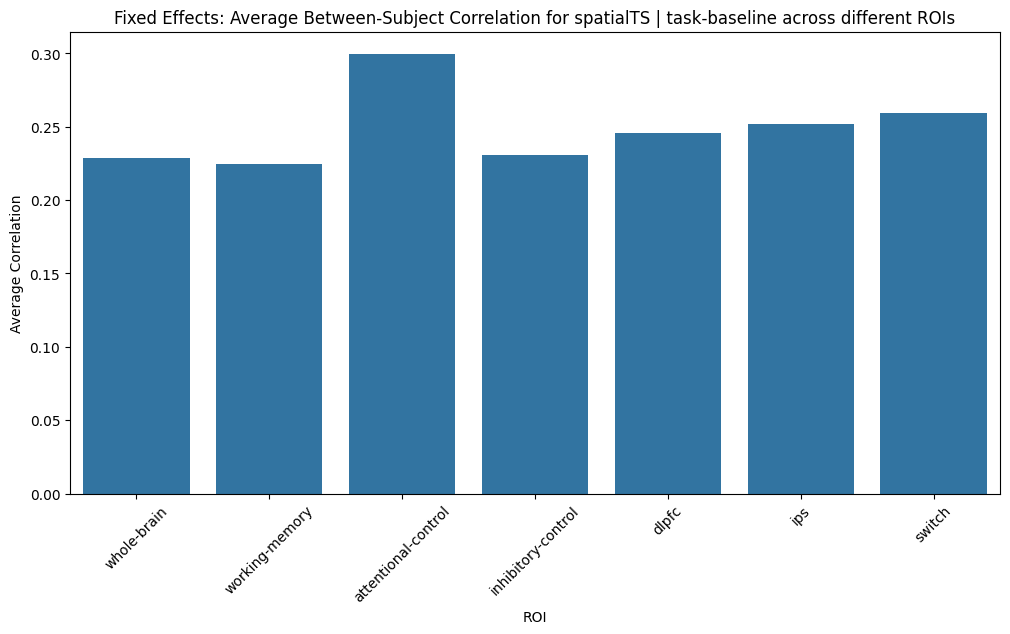

In [16]:
# for each task/contrast, plot the avg between subject correlation for every ROI
# do this for task-baseline and the main contrast separately

for task in fe_corrs_dict.keys():
    for contrast in fe_corrs_dict[task].keys():

        # do this for task-baseline only:
        if (contrast != "task-baseline"):
            continue
        roi_names = fe_corrs_dict[task][contrast]['brain_roi']
        corrs = fe_corrs_dict[task][contrast]['corrs']

        contrast_df = pd.DataFrame({
            'ROI': roi_names,
            'Correlation': corrs,
            'Task': task,
            'Contrast': contrast
        })

        plt.figure(figsize=(12, 6))
        sns.barplot(data=contrast_df, x='ROI', y='Correlation')
        plt.title(f'Fixed Effects: Average Between-Subject Correlation for {task} | {contrast} across different ROIs')
        plt.xticks(rotation=45)
        plt.ylabel('Average Correlation')
        plt.show()

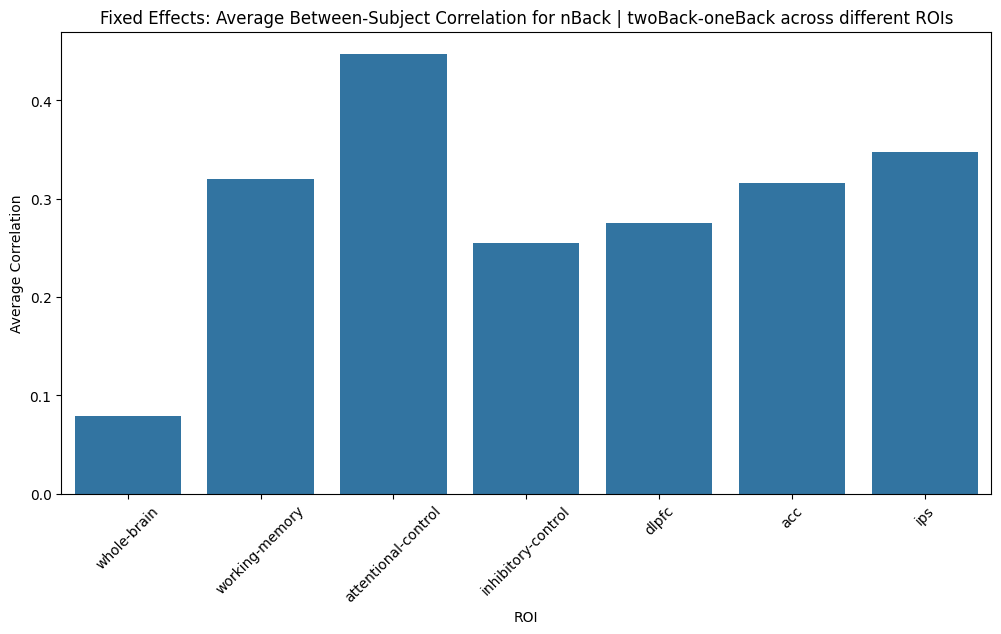

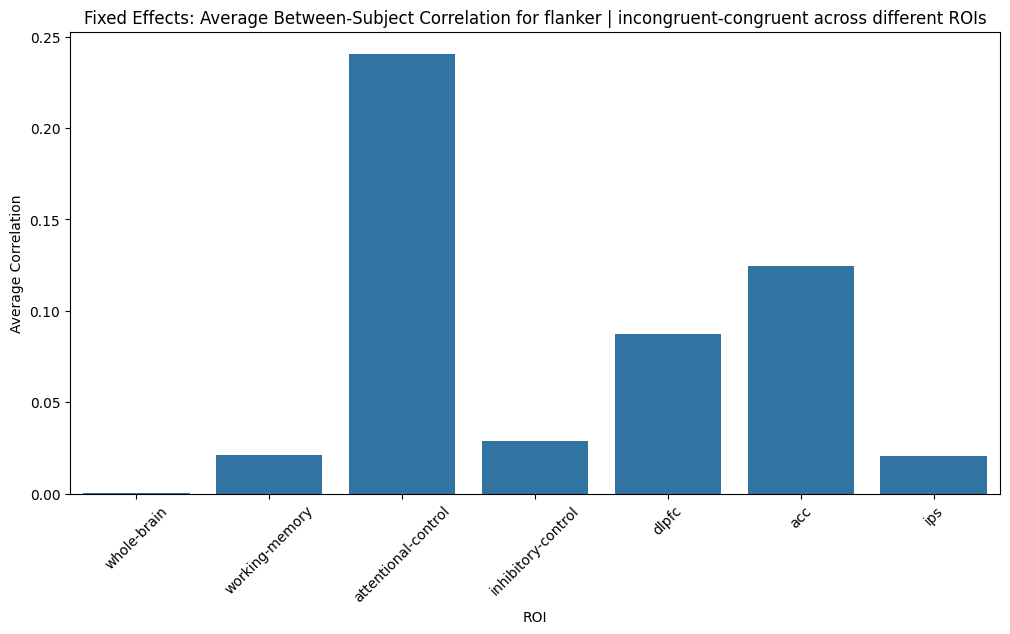

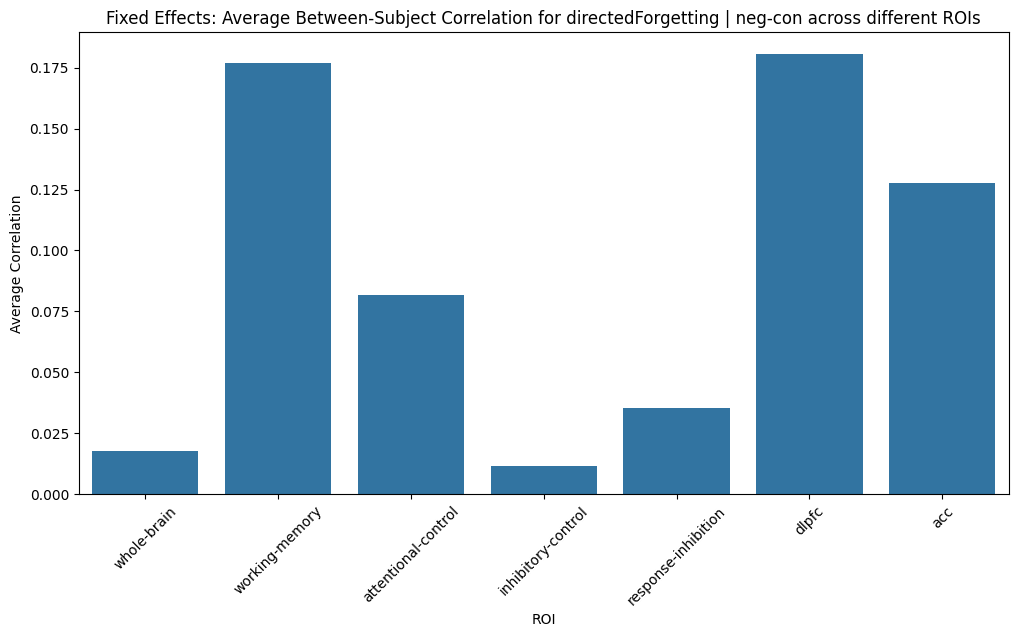

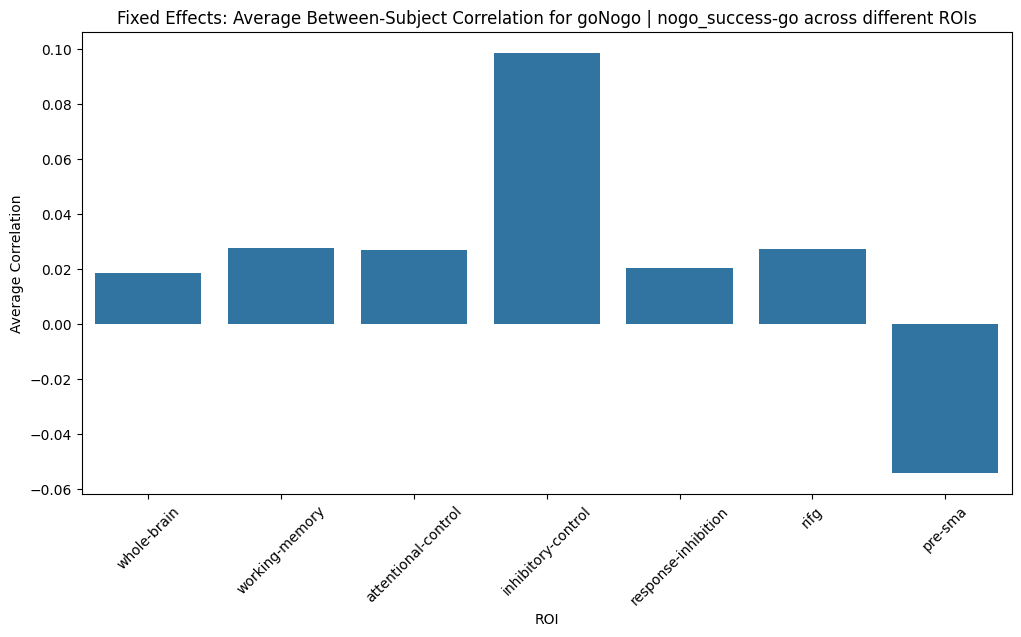

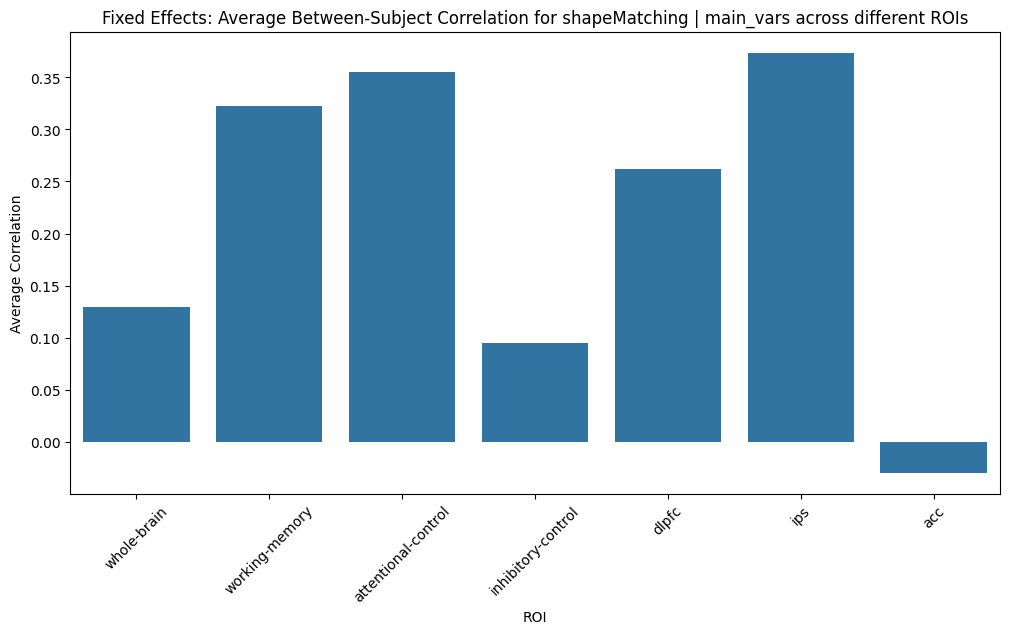

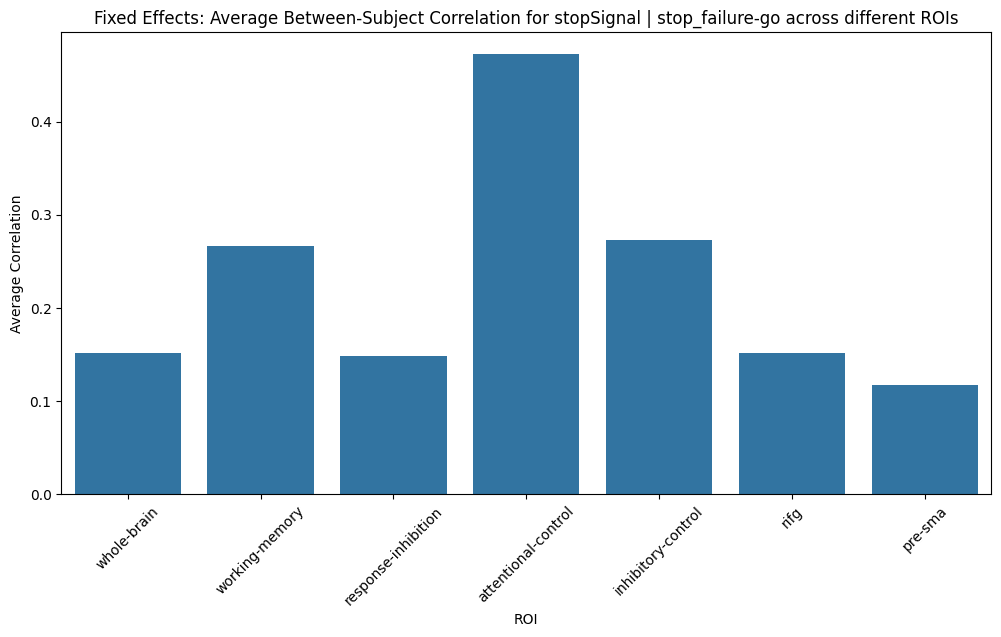

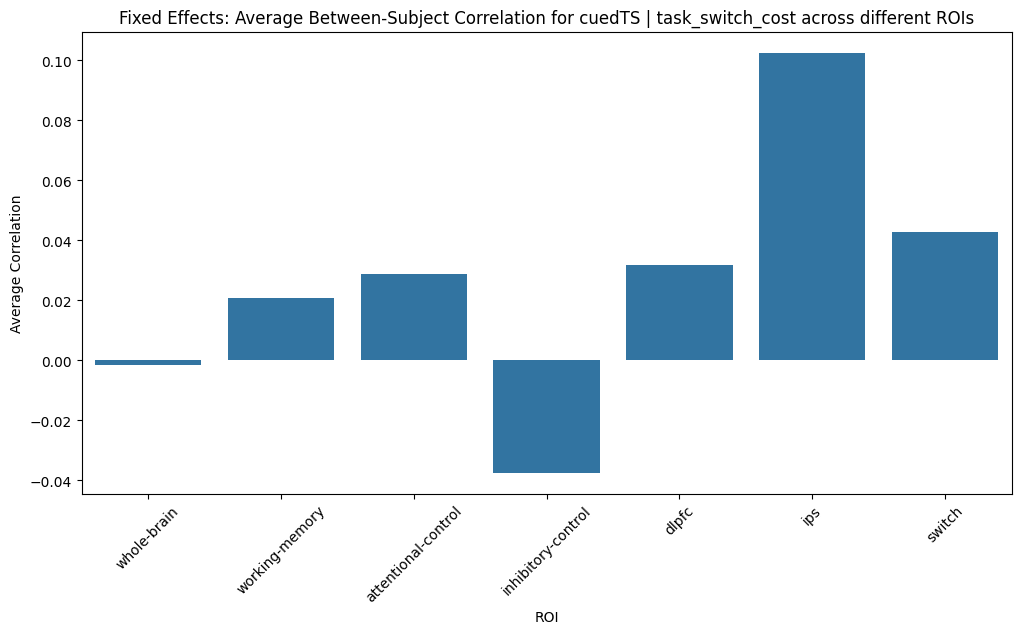

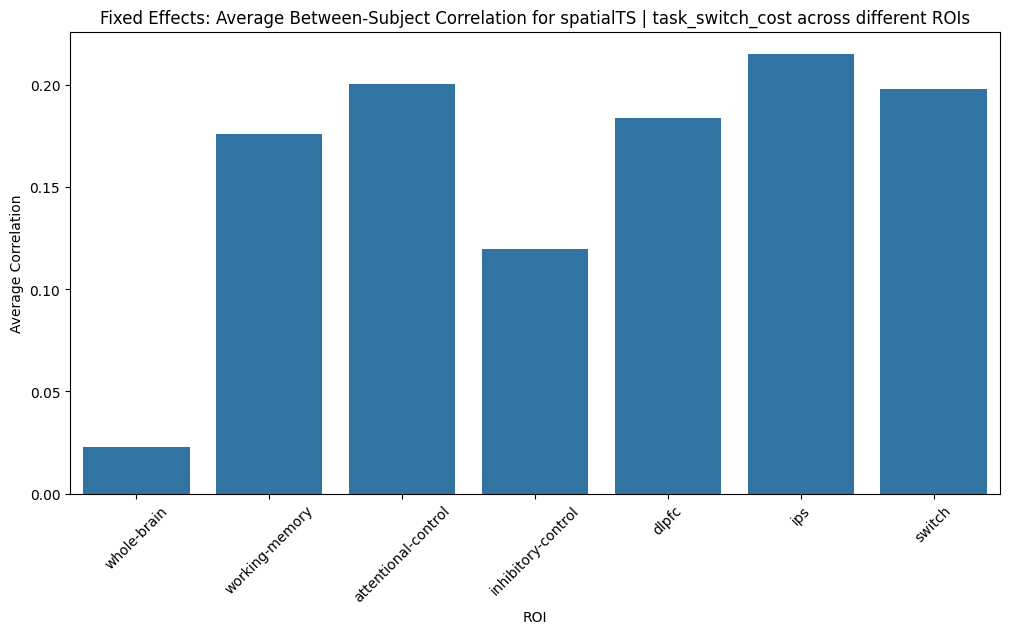

In [17]:
# for each task/contrast, plot the avg between subject correlation for every ROI
# do this for task-baseline and the main contrast separately

for task in fe_corrs_dict.keys():
    for contrast in fe_corrs_dict[task].keys():

        # do this for main contrasts only:
        if (contrast == "task-baseline"):
            continue
        roi_names = fe_corrs_dict[task][contrast]['brain_roi']
        corrs = fe_corrs_dict[task][contrast]['corrs']

        contrast_df = pd.DataFrame({
            'ROI': roi_names,
            'Correlation': corrs,
            'Task': task,
            'Contrast': contrast
        })

        plt.figure(figsize=(12, 6))
        sns.barplot(data=contrast_df, x='ROI', y='Correlation')
        plt.title(f'Fixed Effects: Average Between-Subject Correlation for {task} | {contrast} across different ROIs')
        plt.xticks(rotation=45)
        plt.ylabel('Average Correlation')
        plt.show()

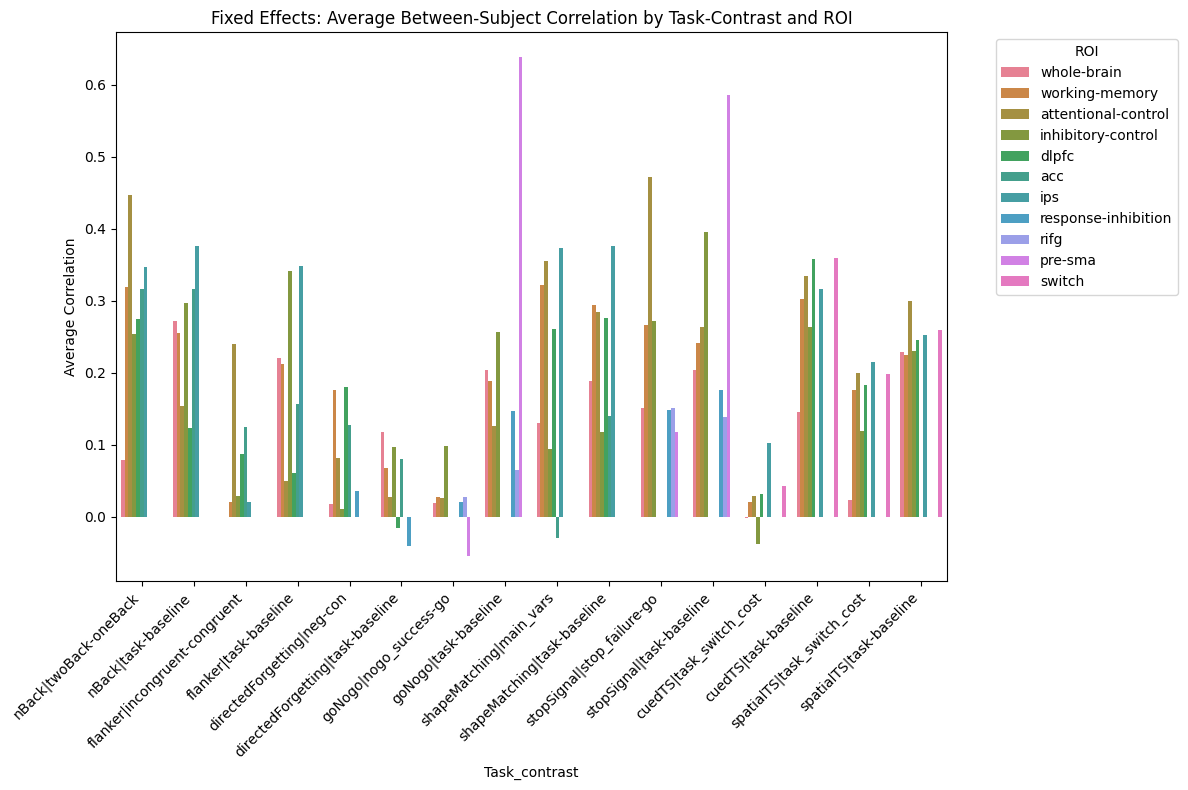

In [21]:
# to put it all in one plot:
data = []

# Loop through the fe_corrs_dict to collect all data
for task in fe_corrs_dict.keys():
    for contrast in fe_corrs_dict[task].keys():

        roi_names = fe_corrs_dict[task][contrast]['brain_roi']
        corrs = fe_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# make a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI' ,errorbar=None)
plt.title('Fixed Effects: Average Between-Subject Correlation by Task-Contrast and ROI')
plt.ylabel('Average Correlation')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

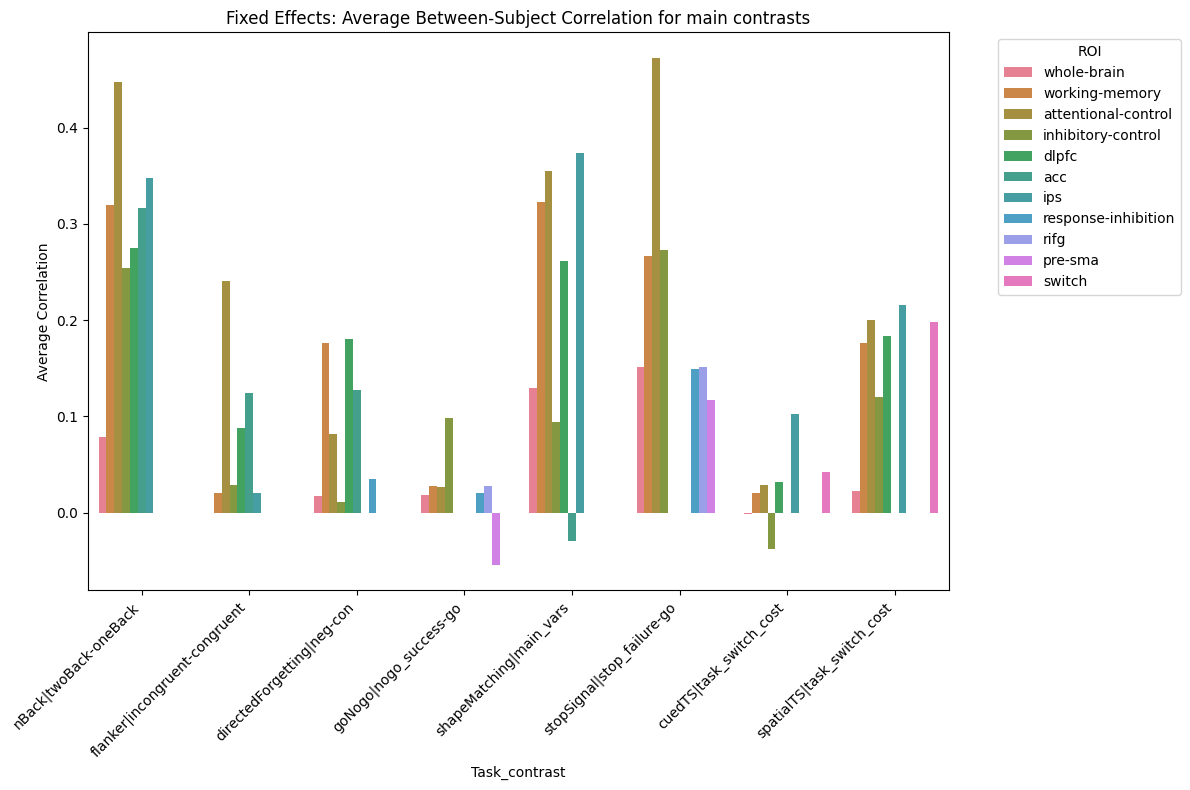

In [22]:
# to put it all in one plot:
data = []

# Loop through the fe_corrs_dict to collect all data
for task in fe_corrs_dict.keys():
    for contrast in fe_corrs_dict[task].keys():

        # remove task-baseline
        if (contrast == "task-baseline"):
            continue
        roi_names = fe_corrs_dict[task][contrast]['brain_roi']
        corrs = fe_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# make a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI',errorbar=None)
plt.title('Fixed Effects: Average Between-Subject Correlation for main contrasts')
plt.ylabel('Average Correlation')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

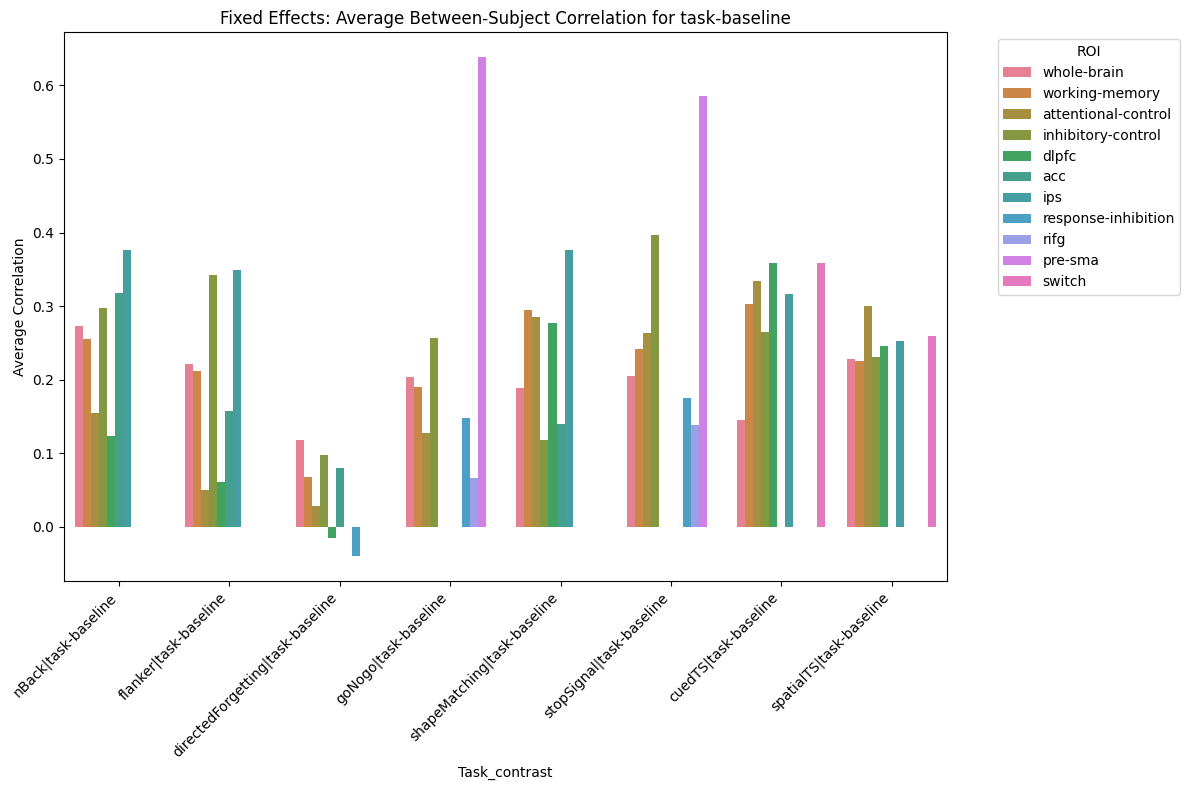

In [24]:
# to put it all in one plot:
data = []

# Loop through the fe_corrs_dict to collect all data
for task in fe_corrs_dict.keys():
    for contrast in fe_corrs_dict[task].keys():

        # remove everything other than task-baseline
        if (contrast != "task-baseline"):
            continue
            
        roi_names = fe_corrs_dict[task][contrast]['brain_roi']
        corrs = fe_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# make a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI',errorbar=None)
plt.title('Fixed Effects: Average Between-Subject Correlation for task-baseline')
plt.ylabel('Average Correlation')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

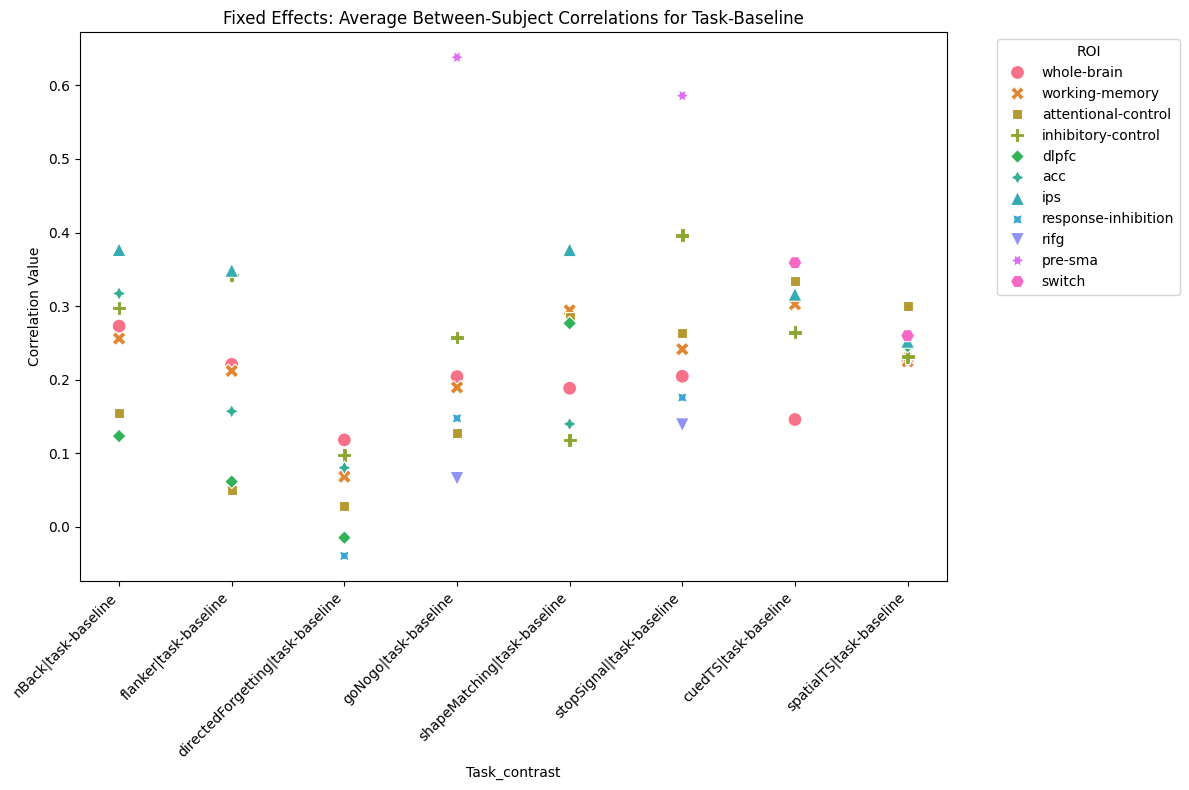

In [25]:
# to put it all in one plot:
data = []

# Loop through the fe_corrs_dict to collect all data
for task in fe_corrs_dict.keys():
    for contrast in fe_corrs_dict[task].keys():

        # remove everything other than task-baseline
        if (contrast != "task-baseline"):
            continue
            
        roi_names = fe_corrs_dict[task][contrast]['brain_roi']
        corrs = fe_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI',style = 'ROI',s=100, alpha=1)

plt.title('Fixed Effects: Average Between-Subject Correlations for Task-Baseline')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

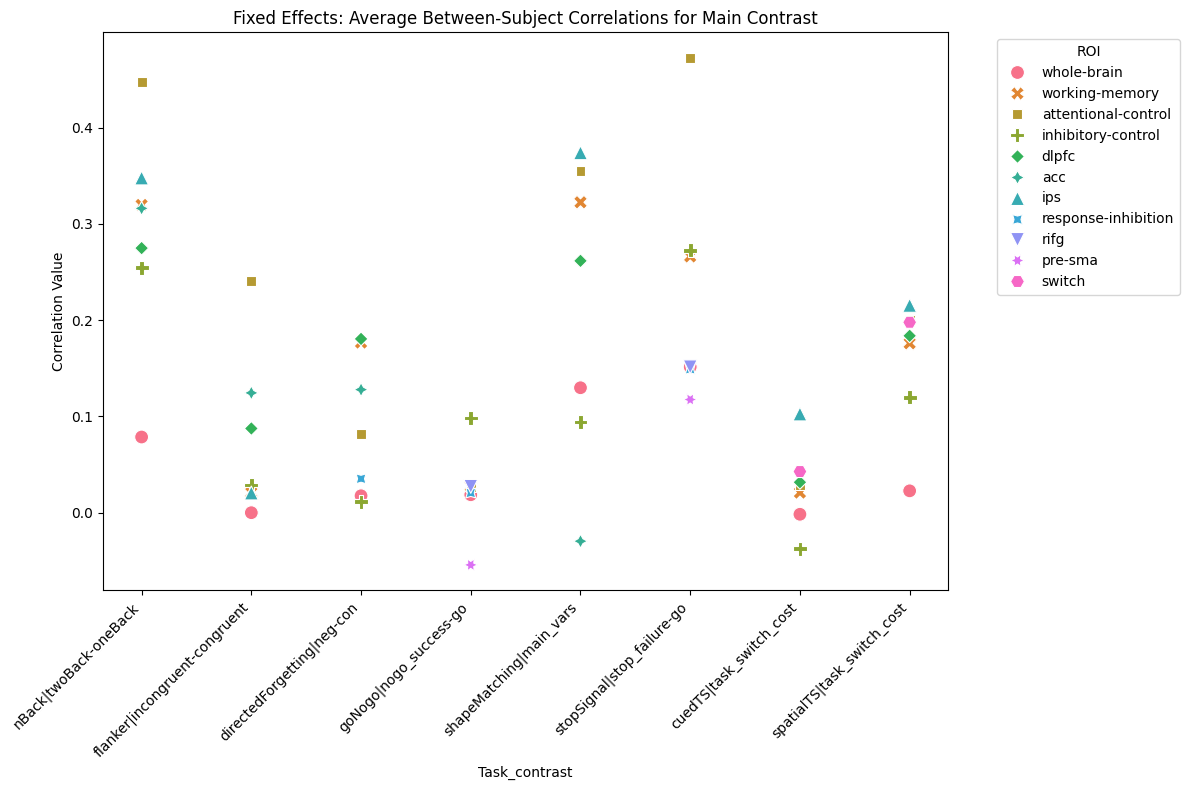

In [26]:
# to put it all in one plot:
data = []

# Loop through the fe_corrs_dict to collect all data
for task in fe_corrs_dict.keys():
    for contrast in fe_corrs_dict[task].keys():

        # remove everything other than task-baseline
        if (contrast == "task-baseline"):
            continue
            
        roi_names = fe_corrs_dict[task][contrast]['brain_roi']
        corrs = fe_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI',style = 'ROI',s=100, alpha=1)

plt.title('Fixed Effects: Average Between-Subject Correlations for Main Contrast')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

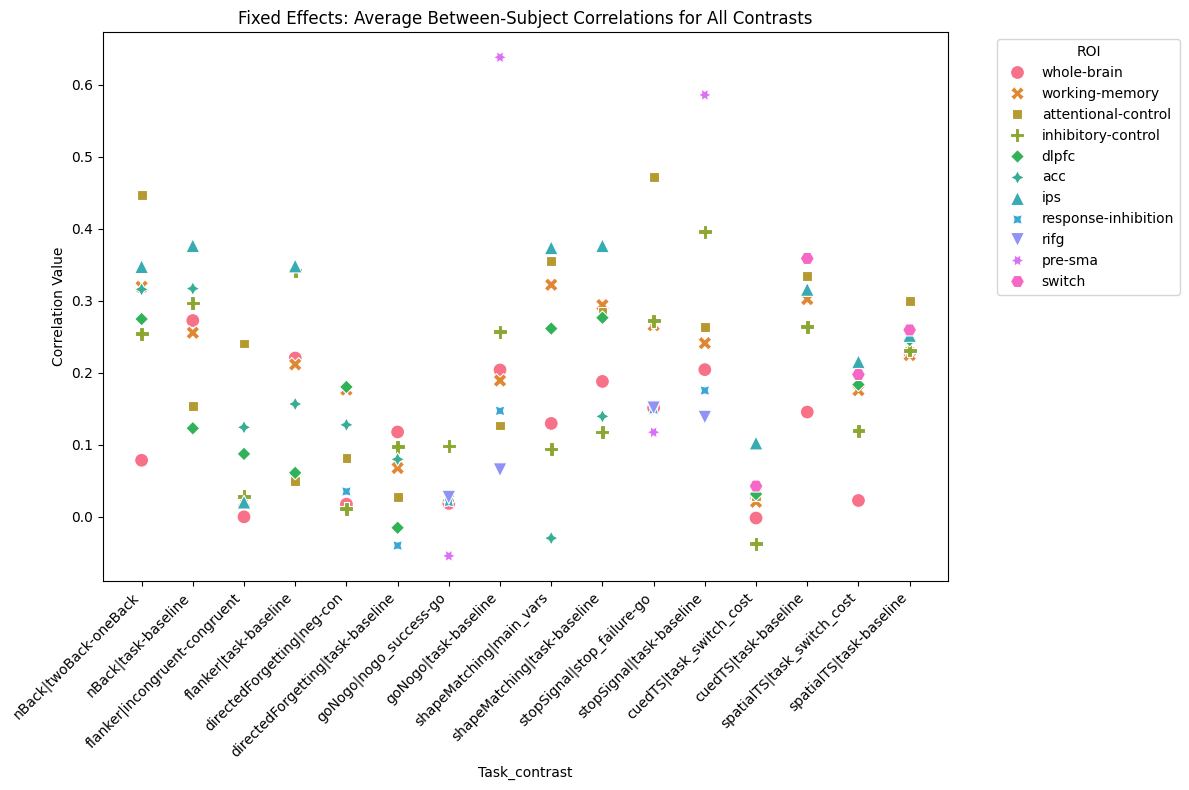

In [27]:
# to put it all in one plot:
data = []

# Loop through the fe_corrs_dict to collect all data
for task in fe_corrs_dict.keys():
    for contrast in fe_corrs_dict[task].keys():
            
        roi_names = fe_corrs_dict[task][contrast]['brain_roi']
        corrs = fe_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI',style = 'ROI',s=100, alpha=1)

plt.title('Fixed Effects: Average Between-Subject Correlations for All Contrasts')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# individual contrasts: 

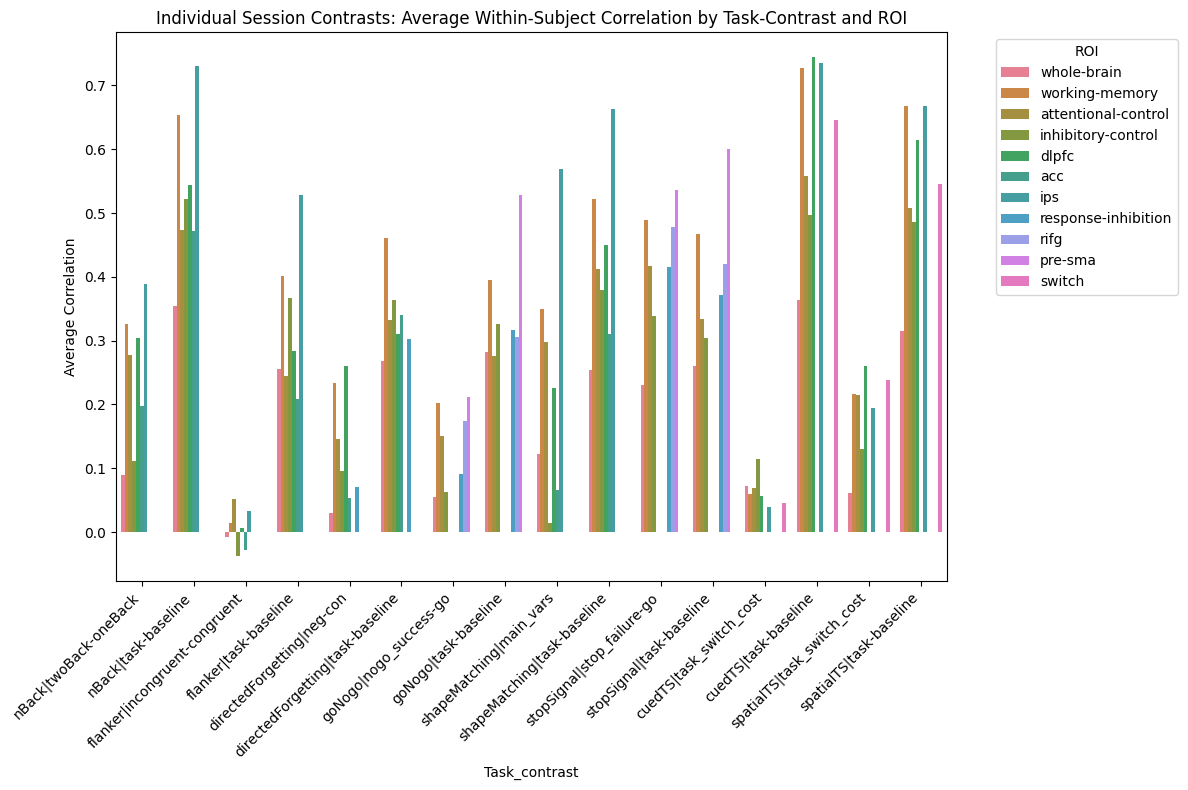

In [40]:
# to put it all in one plot:
data = []

# Loop through the fe_corrs_dict to collect all data
for task in indiv_corrs_dict.keys():
    for contrast in indiv_corrs_dict[task].keys():

        roi_names = indiv_corrs_dict[task][contrast]['brain_roi']
        corrs = indiv_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# make a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI', errorbar=None)
plt.title('Individual Session Contrasts: Average Within-Subject Correlation by Task-Contrast and ROI')
plt.ylabel('Average Correlation')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

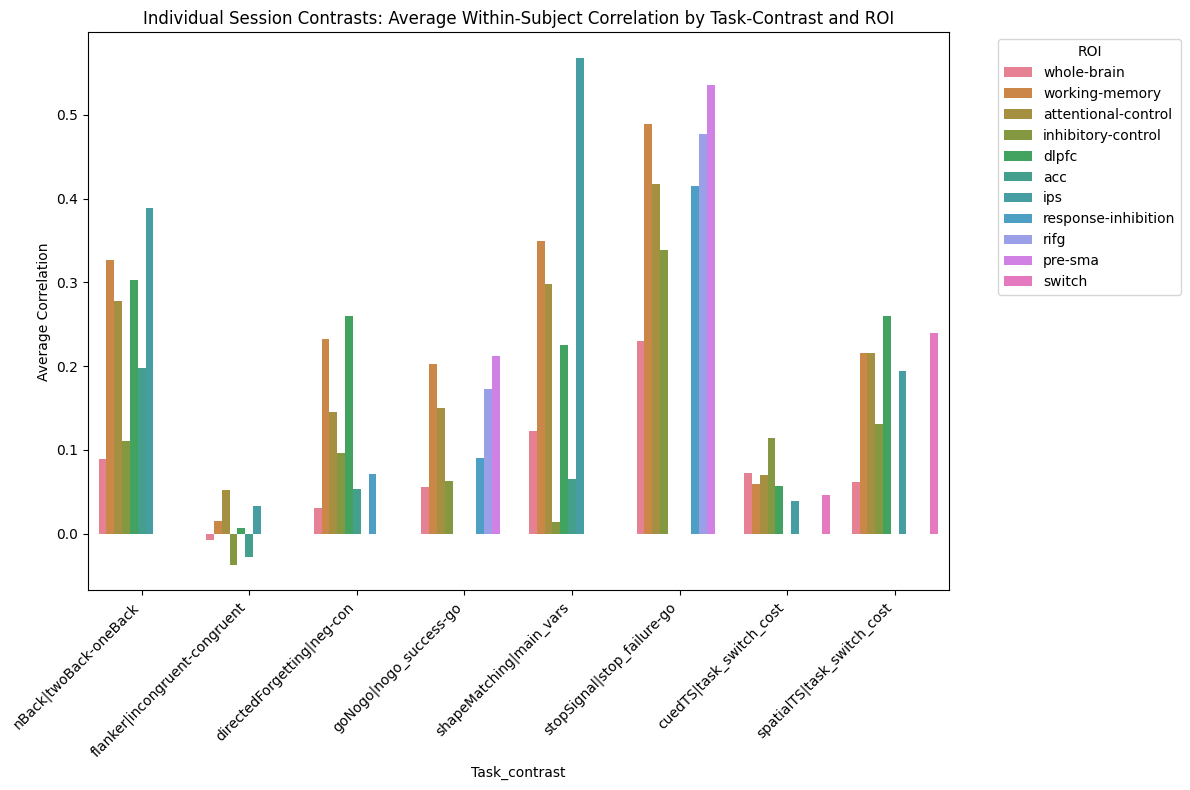

In [41]:
# to put it all in one plot:
data = []

# Loop through the indiv_corrs_dict to collect all data
for task in indiv_corrs_dict.keys():
    for contrast in indiv_corrs_dict[task].keys():
        if (contrast == "task-baseline"):
            continue

        roi_names = indiv_corrs_dict[task][contrast]['brain_roi']
        corrs = indiv_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# make a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI', errorbar=None)
plt.title('Individual Session Contrasts: Average Within-Subject Correlation by Task-Contrast and ROI')
plt.ylabel('Average Correlation')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

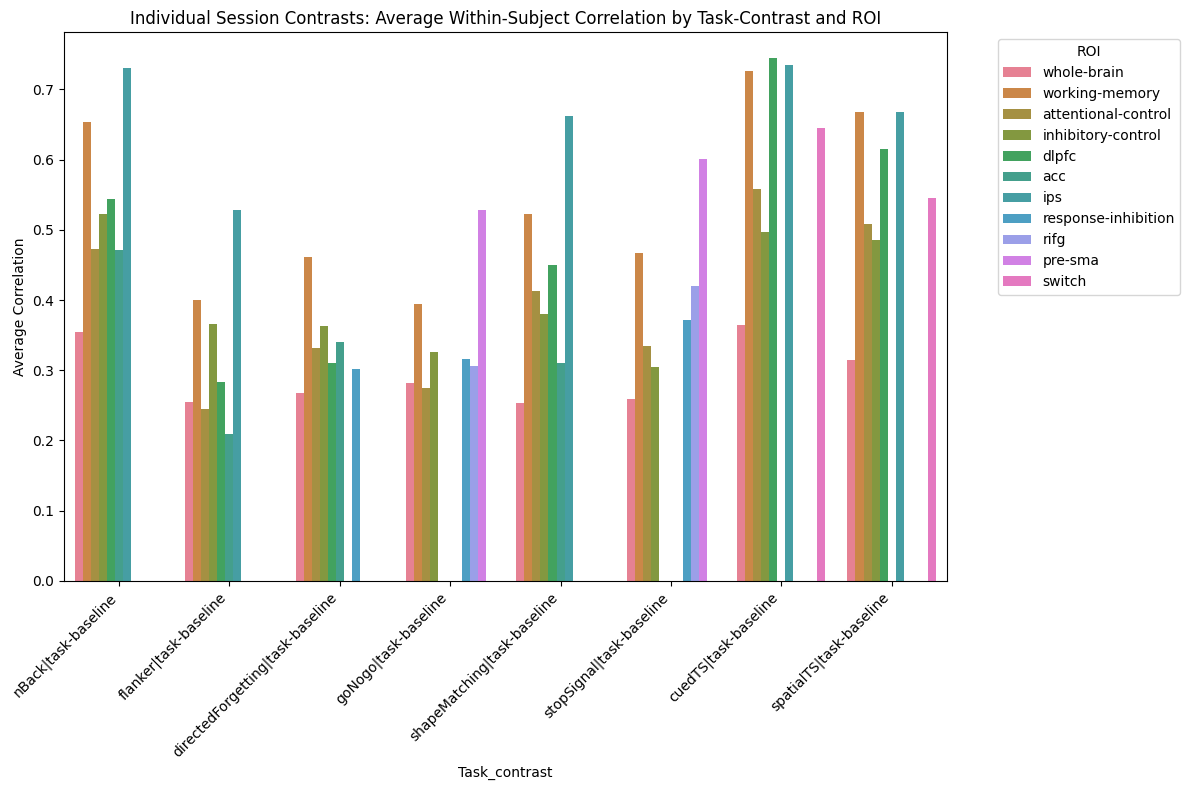

In [42]:
# to put it all in one plot:
data = []

# Loop through the indiv_corrs_dict to collect all data
for task in indiv_corrs_dict.keys():
    for contrast in indiv_corrs_dict[task].keys():
        if (contrast != "task-baseline"):
            continue

        roi_names = indiv_corrs_dict[task][contrast]['brain_roi']
        corrs = indiv_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# make a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI', errorbar=None)
plt.title('Individual Session Contrasts: Average Within-Subject Correlation by Task-Contrast and ROI')
plt.ylabel('Average Correlation')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

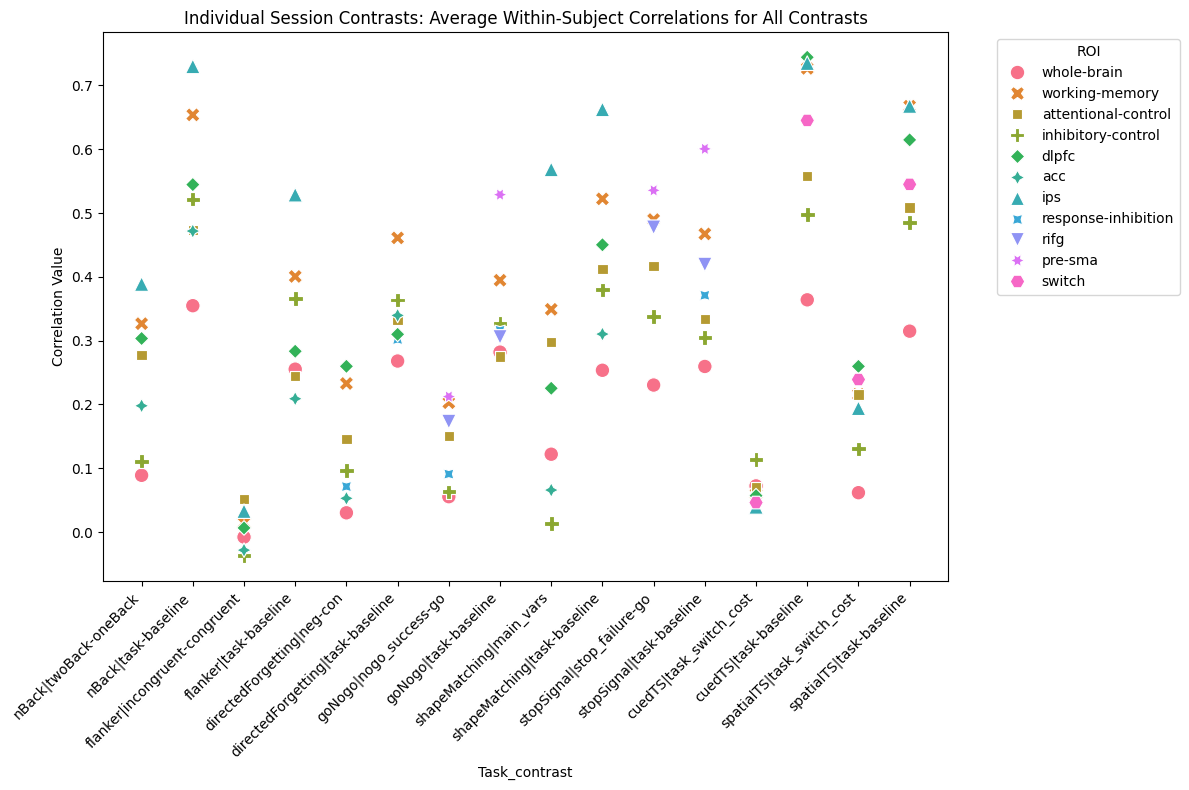

In [43]:
# to put it all in one plot:
data = []

# Loop through the fe_corrs_dict to collect all data
for task in indiv_corrs_dict.keys():
    for contrast in indiv_corrs_dict[task].keys():
            
        roi_names = indiv_corrs_dict[task][contrast]['brain_roi']
        corrs = indiv_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI',style = 'ROI',s=110, alpha=1)

plt.title('Individual Session Contrasts: Average Within-Subject Correlations for All Contrasts')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

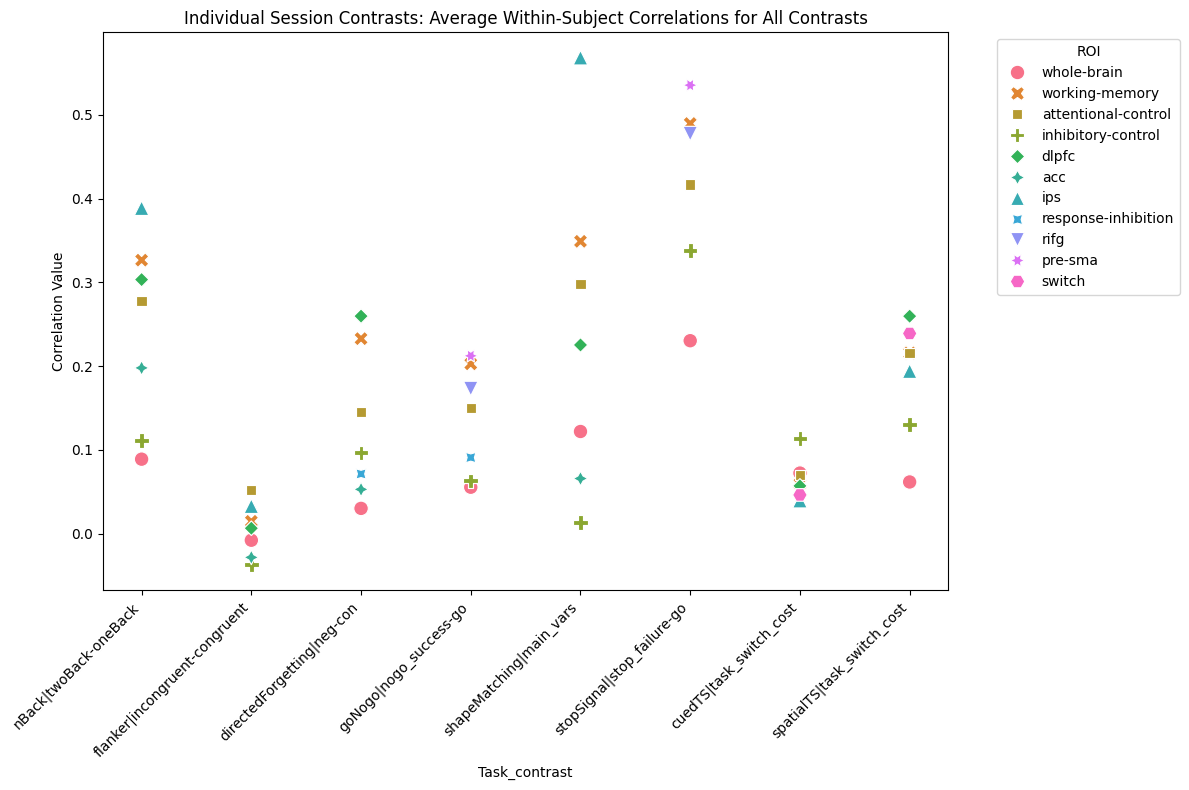

In [44]:
# to put it all in one plot:
data = []

# Loop through the fe_corrs_dict to collect all data
for task in indiv_corrs_dict.keys():
    for contrast in indiv_corrs_dict[task].keys():
        if (contrast == "task-baseline"):
            continue
            
        roi_names = indiv_corrs_dict[task][contrast]['brain_roi']
        corrs = indiv_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI',style = 'ROI',s=110, alpha=1)

plt.title('Individual Session Contrasts: Average Within-Subject Correlations for All Contrasts')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

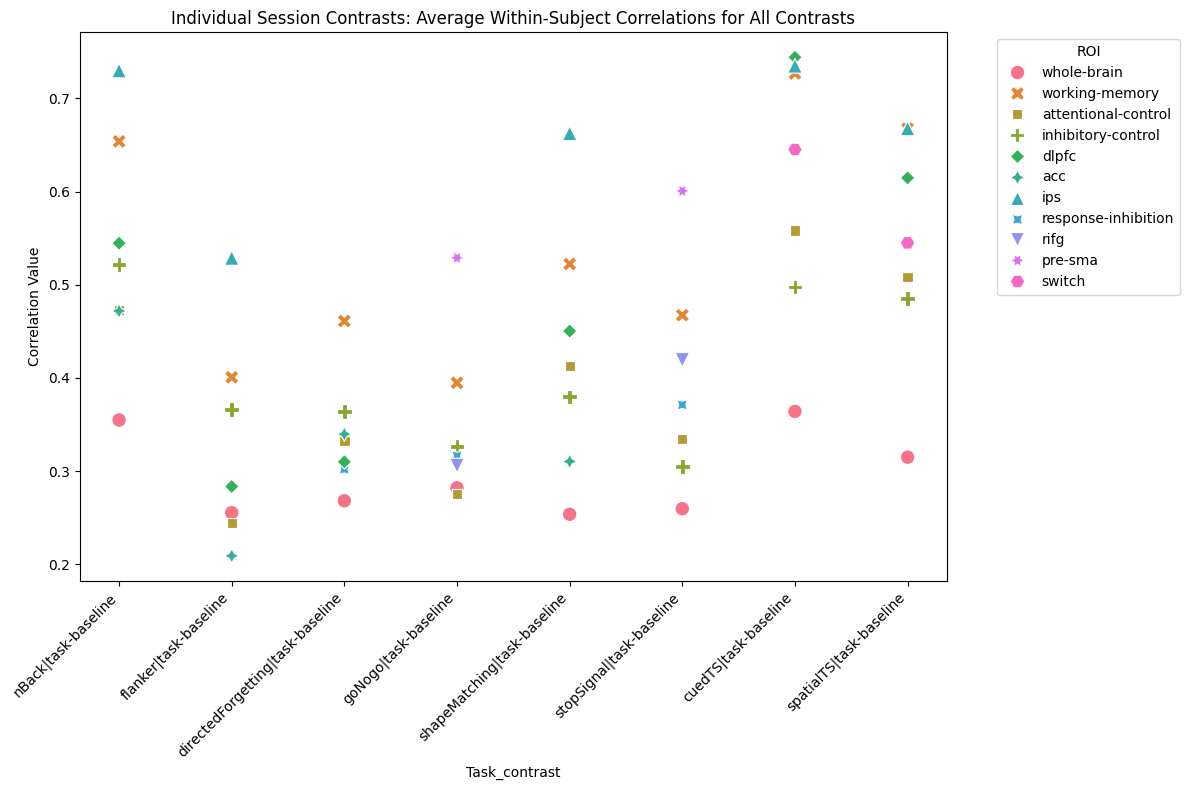

In [45]:
# to put it all in one plot:
data = []

# Loop through the fe_corrs_dict to collect all data
for task in indiv_corrs_dict.keys():
    for contrast in indiv_corrs_dict[task].keys():
        if (contrast != "task-baseline"):
            continue
            
        roi_names = indiv_corrs_dict[task][contrast]['brain_roi']
        corrs = indiv_corrs_dict[task][contrast]['corrs']

        # Loop through each ROI and correlation
        for roi, corr in zip(roi_names, corrs):
            data.append({
                'ROI': roi,
                'Correlation': corr,
                'Task_contrast': f"{task}|{contrast}",
                'Contrast': contrast
            })
# Create df
full_df = pd.DataFrame(data)

# scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=full_df, x='Task_contrast', y='Correlation', hue='ROI',style = 'ROI',s=110, alpha=1)

plt.title('Individual Session Contrasts: Average Within-Subject Correlations for All Contrasts')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45, ha="right")
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()